<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/torch/notebooks/CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can comment out the colab setup / local setup depending on where you want to run the code.

## Colab setup and load dataset

The dataset *must already be downloaded* in your Google Drive. The location is specfied by the variable `GDRIVE_CELEBA_PATH`. If not please download directly from the [source](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ). All we need is `img_align_celeba.zip`.

Installs and imports the necessary modules. Variables of interest:

* `CHECKPOINTS_PATH`: The directory where the checkpoints will be saved.
* `GDRIVE_CELEBA_PATH`: The directory where `img_align_celeba.zip` is located on GDrive

In [ ]:
# Install missing modules
%%capture
# Install missing packages
!pip install torchtyping
!pip install wandb
!pip install torchmetrics[image]

#from pathlib import Path
from google.colab import drive

# Import custom modules
import sys
from pathlib import Path
CHECKPOINTS_PATH = Path('/content/gdrive/MyDrive/ParEM/celeba/checkpoints')

!rm -rf ParEM
!git clone https://github.com/juankuntz/ParEM.git
REPOSITORY_PATH = '/content/ParEM/torch'
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

drive.mount("/content/gdrive", force_remount=False)
GDRIVE_CELEBA_PATH = Path("/content/gdrive/MyDrive/datasets/celeba")
LOCAL_CELEBA_DIR_PATH = Path("/content/") / "celeba"
assert GDRIVE_CELEBA_PATH.is_dir()
if not LOCAL_CELEBA_DIR_PATH.is_dir():
  !cp -r $GDRIVE_CELEBA_PATH -d /content/
  img_aligned_zip_path = LOCAL_CELEBA_DIR_PATH / "img_align_celeba.zip"
  !unzip $img_aligned_zip_path -d $LOCAL_CELEBA_DIR_PATH

## Local setup and load dataset

The dataset *must already be downloaded* in your local drive. The location is specfied by the variable `img_aligned_zip_path`. If not please download directly from the [source](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ). All we need is `img_align_celeba.zip`.

Variables of interest:

* `img_aligned_zip_path`: The path to `img_align_celeba.zip`.
* `CHECKPOINTS_PATH`: The directory where the checkpoints will be saved.
* `LOCAL_CELEBA_DIR_PATH`: Path to where `img_align_celeba.zip` will be unzipped.

In [ ]:
# import sys
# REPOSITORY_PATH = "../"
# if REPOSITORY_PATH not in sys.path:
#     sys.path.append(REPOSITORY_PATH)
# CHECKPOINTS_PATH = Path('./checkpoints')
# img_aligned_zip_path = 'PATH_TO_img_align_celeba.zip'
# LOCAL_CELEBA_DIR_PATH = 'LOCATION_WHERE_TO_UNZIP'
# if not LOCAL_CELEBA_DIR_PATH.is_dir():
#   !unzip $img_aligned_zip_path -d $LOCAL_CELEBA_DIR_PATH

# General Setup

In [ ]:
# Import standard modules
import torch
import numpy as np
import matplotlib.pyplot as plt

# Import custom modules
from parem.models import NLVM
from parem.algorithms import (PGD,
                              ShortRun,
                              VI,
                              AlternatingBackprop)
from parem.utils import get_celeba, load_checkpoint

dataset = get_celeba(LOCAL_CELEBA_DIR_PATH / "img_align_celeba", N_IMAGES)  # Load dataset

# Set config variables

In [ ]:
# Data setttings
N_IMAGES = 10000  # M: training set size 

# Training settings
N_BATCH = 128 # M_b: batch size for theta updates
N_EPOCHS = 100 # n_epochs = K * M_b / M where K = total number of iterations
SEED = 1 # Seed for PRNG
# Device on which to carry out computations:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OPTIMIZER = 'rmsprop'  # Theta optimizer

# Model Settings
X_DIM = 64  # d_x: dimension of latent space
LIKELIHOOD_VAR = 0.01 ** 2  # sigma^2

# PGD Settings
STEP_SIZE = 1e-4 # h: step size 
LAMBDA = 1e-3 / (STEP_SIZE * N_IMAGES)  # lambda
N_PARTICLES = 10 # N: number of particles

# Define model and training algorithm

The training algorithm selected here is `PGD`. Other algorithms have been implemented in the paper such as:

* [Short Run MCMC](https://arxiv.org/abs/1912.01909) using the class called `ShortRun`.
* [Variational Inference](https://arxiv.org/pdf/1312.6114.pdf) using the class called `VI`.
* [Alternating Backpropagation](https://arxiv.org/abs/1606.08571) using the class called `AlternatingBackprop`.

Their interface is similar to `PGD`, this can be seen in `torch/parem/algorithm`.

In [ ]:
# # Define model:
model = NLVM(x_dim=X_DIM, sigma2=LIKELIHOOD_VAR, nc=3).to(DEVICE)

# Define training algorithm:
pgd = PGD(model=model, lambd=LAMBDA, dataset=dataset, train_batch_size=N_BATCH,
                          particle_step_size=STEP_SIZE, device=DEVICE,
                          theta_optimizer=OPTIMIZER)

# Train Model

Calling `{PGD , VI, AlternatingBackprop, ShortRun}.run(...)` will train the model using the respective algorithm. The function has several optional arguments to have more transparency about the progress during training
* `wandb_log`: Using [Weights and Biases](https://wandb.ai/site) to log the training.
* `log_images`: Logged images using [Weights and Biases](https://wandb.ai/site).
* `compute_stats`: Compute FID, and MSE during training process.

In [ ]:
pgd.run(N_EPOCHS, CHECKPOINTS_PATH / '/celeba_vae1.pt', compute_stats=False, wandb_log=False, log_images=False)

...............................................................................Epoch 0: Loss 5836867.234,
...............................................................................Epoch 1: Loss 4577683.180,
...............................................................................Epoch 2: Loss 3389909.089,
...............................................................................Epoch 3: Loss 2436908.354,
...............................................................................Epoch 4: Loss 1952428.919,
...............................................................................Epoch 5: Loss 1685837.571,
...............................................................................Epoch 6: Loss 1521562.486,
...............................................................................Epoch 7: Loss 1369793.453,
...............................................................................Epoch 8: Loss 1283295.141,
..............................................

# Show particle cloud

Calling `{PGD , VI, AlternatingBackprop, ShortRun}.sample_image_posterior(...)` will be able to view the image that corresponds to the latent variable of an image from the training dataset. The first argument is the index of the training image and the second the number of particles to visualize.

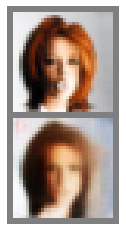

In [ ]:
pgd.sample_image_posterior(10, 1)

# Generate synthetic samples

Generate samples from the model using `{PGD , VI, AlternatingBackprop, ShortRun}.synthesize_images(...)`. The optional argument `approx_type` specifies the approximation used on the posterior. If
* `approx_type` is `gmm`. A Gaussian Mixture distribution is used, and `n_components` option specifies the number of components.
* `approx_type` is `gaussian`. A Gaussian distribution is used.

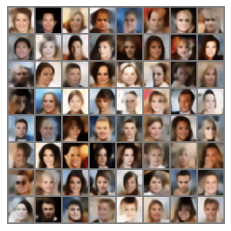

In [ ]:
 _ = pgd.synthesize_images(n=64, approx_type='gmm', n_components=100)

# Inpainting
Calling `{PGD , VI, AlternatingBackprop, ShortRun}.reconstruct(img, mask=None)` will retrun the reconstruction of `img`. If `mask` is not `None`, then a partially occluded image is passed in and the result can be used to impute the missing pixels specified by the `mask`.

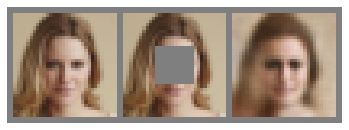

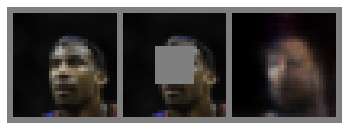

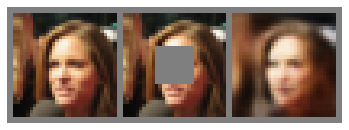

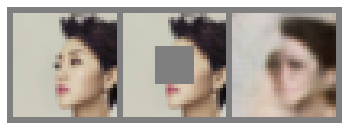

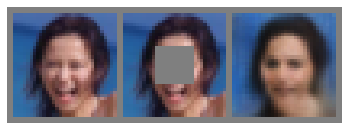

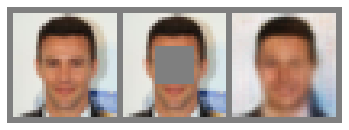

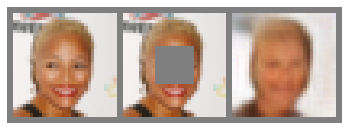

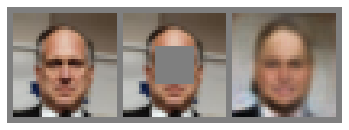

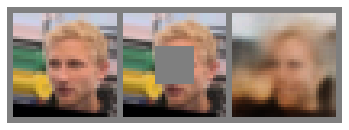

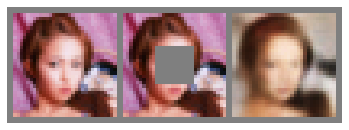

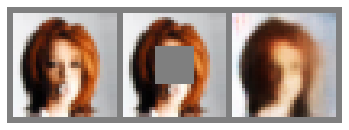

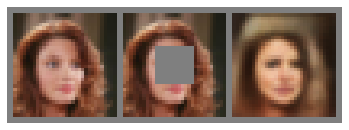

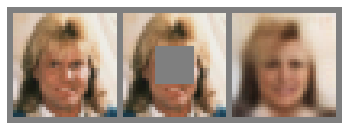

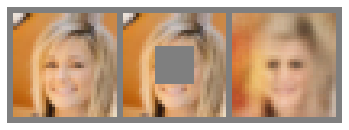

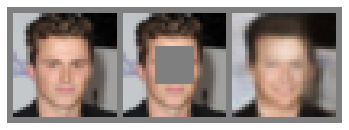

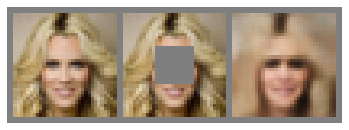

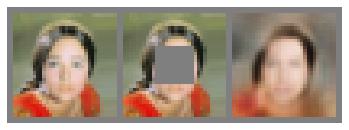

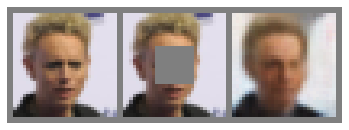

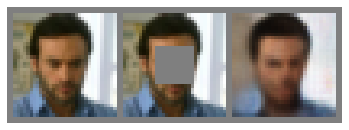

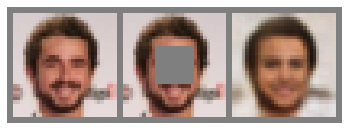

In [ ]:
n_missing_img = 20
images = torch.stack(dataset[:n_missing_img][0], dim=0)
mask = torch.ones(dataset.height, dataset.width, dtype=torch.bool)

for i in range(10, 22):
    for j in range(10, 22):
        mask[i, j] = False

_ = pgd.reconstruct(images, mask)